In [ ]:
# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
 
#Extract the Dataset
!unrar x UCF50.rar

In [2]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9 MB 8.4 MB/s 


In [3]:
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

import pafy
import math
import random
import datetime as dt
from collections import deque
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1695744/45929032 bytes (3.7%)3817472/45929032 bytes (8.3%)5357568/45929032 bytes (11.7%)6946816/45929032 bytes (15.1%)8921088/45929032 bytes (19.4%)10952704/45929032 bytes (23.8%)12820480/45929032 bytes (27.9%)15081472/45929032 bytes (32.8%)17596416/45929032 bytes (38.3%)19406848/45929032 bytes (42.3%)21774336/45929032 bytes (47.4%)24043520/45929032 bytes (52.3%)26746

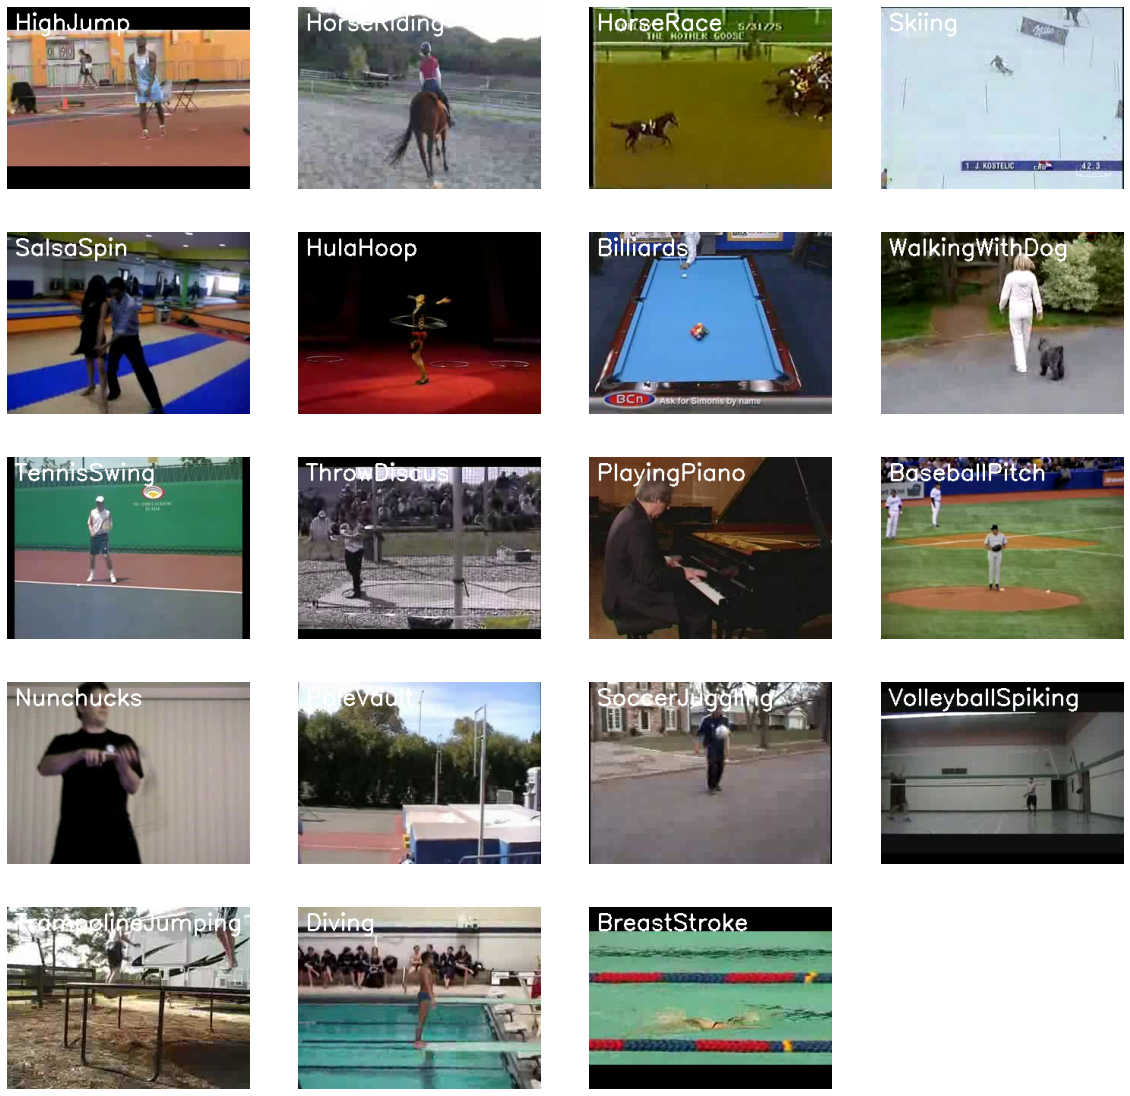

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 19)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [5]:
IMAGE_HEIGHT , IMAGE_WIDTH = 96, 96
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "UCF50"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Diving", "Biking", "Fencing", "HorseRace"]

In [6]:
def frames_extraction(video_path):
 
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 127.5
        normalized_frame = normalized_frame - 1
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [7]:
def create_dataset():
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [8]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Diving
Extracting Data of Class: Biking
Extracting Data of Class: Fencing
Extracting Data of Class: HorseRace


In [9]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = 27)

In [11]:
def create_model():


  feature_extractor = keras.applications.mobilenet_v2.MobileNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH , 3),
    )
  
  feature_extractor.trainable = True

  fine_tune_at = 120

  for layer in feature_extractor.layers[:fine_tune_at]:
     layer.trainable = False
    
 
    # We will use a Sequential model for model construction.
  model = Sequential()
    
    # Define the Model Architecture.
  
    
  model.add(TimeDistributed(feature_extractor,
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
     
                                      
  model.add(LSTM(32))
                                      
  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
  
 
    # Display the models summary.
  model.summary()
    
    # Return the constructed LRCN model.
  return model

In [12]:
# Construct the required LRCN model.
model = create_model()
 
# Display the success message.
print("Model Created Successfully!")

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 1280)         2257984   
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 32)                168064    
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 2,426,180
Trainable params: 1,793,092
Non-trainable params: 633,088
_________________________________________________________________
Model Created Successfully!


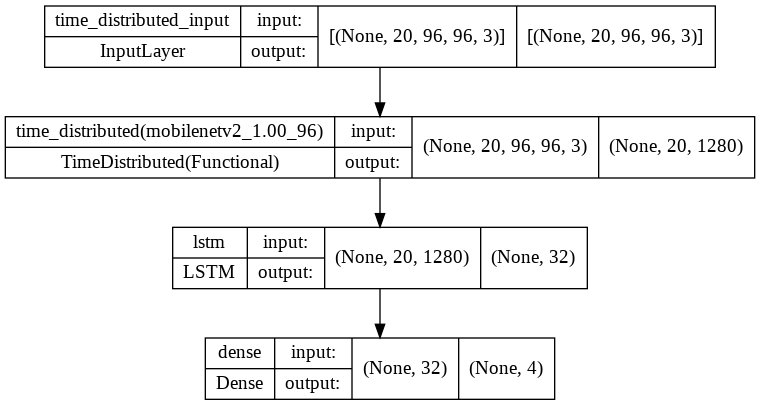

In [13]:
# Plot the structure of the contructed LRCN model.
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [14]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/70
81/81 [==============================] - 29s 156ms/step - loss: 0.6869 - accuracy: 0.7321 - val_loss: 0.7510 - val_accuracy: 0.7160
Epoch 2/70
81/81 [==============================] - 9s 115ms/step - loss: 0.4754 - accuracy: 0.8380 - val_loss: 1.0989 - val_accuracy: 0.5432
Epoch 3/70
81/81 [==============================] - 9s 115ms/step - loss: 0.6011 - accuracy: 0.7788 - val_loss: 1.5625 - val_accuracy: 0.4568
Epoch 4/70
81/81 [==============================] - 9s 114ms/step - loss: 0.3413 - accuracy: 0.8816 - val_loss: 1.1257 - val_accuracy: 0.5432
Epoch 5/70
81/81 [==============================] - 9s 115ms/step - loss: 0.3265 - accuracy: 0.9034 - val_loss: 1.3382 - val_accuracy: 0.5556
Epoch 6/70
81/81 [==============================] - 9s 115ms/step - loss: 0.4210 - accuracy: 0.8411 - val_loss: 0.8174 - val_accuracy: 0.6543
Epoch 7/70
81/81 [==============================] - 9s 115ms/step - loss: 0.1769 - accuracy: 0.9470 - val_loss: 1.5874 - val_accuracy: 0.3457
Epoch

In [15]:
# Evaluate the trained model.
model_evaluation_history = model.evaluate(features_test, labels_test)

5/5 [==============================] - 4s 379ms/step - loss: 0.1297 - accuracy: 0.9552


In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

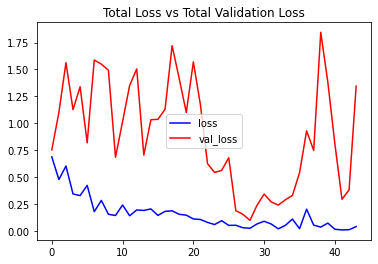

In [17]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

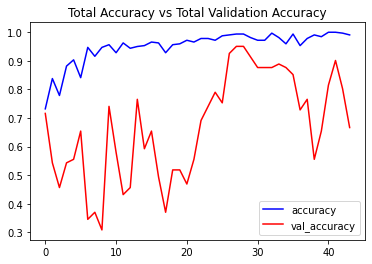

In [18]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [19]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 127.5
        normalized_frame = normalized_frame - 1
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
 
        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [20]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

In [21]:
video_title = 'v_HorseRace_g01_c02'

In [22]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
 
# Perform Action Recognition on the Test Video.
predict_on_video('/content/UCF50/HorseRace/v_HorseRace_g01_c02.avi', output_video_file_path, SEQUENCE_LENGTH)
 
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 154/154 [00:00<00:00, 290.91it/s]


In [23]:

def predict_single_action(video_file_path, SEQUENCE_LENGTH):
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Read a frame.
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 127.5
        normalized_frame = normalized_frame - 1
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

In [24]:
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
 
# Perform Single Prediction on the Test Video.
predict_single_action('/content/UCF50/HorseRace/v_HorseRace_g01_c02.avi', SEQUENCE_LENGTH)
 
# Display the input video.
#VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()


Action Predicted: HorseRace
Confidence: 0.998816728591919
